## ---------------------------------- AIRBNB HOUSING PRICE PREDICTION ------------------------------------
### Below code contains functions to clean the dataset, modelling using KNN Regressor, Random Forest and Decision Tree Regressor and comparison of the models to choose the best model to predict the values

## Import the data listings file of Boston Airbnb

In [474]:
import pandas as pd

df= pd.read_csv('../data/airbnb.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (53,106) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [475]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Make all the necessary imports

In [476]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsRegressor

#### Check the columns and the shape of the dataset

In [477]:
print(df.shape)
print(df.columns.tolist())

(61280, 107)
['Unnamed: 0', 'access', 'accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee', 'country', 'country_code', 'description', 'experiences_offered', 'extra_people', 'first_review', 'guests_included', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'house_rules', 'id', 'instant_bookable', 'interac

## Removing speical characters

In [478]:
def spcl_char(df):
    df['extra_people'] = df['extra_people'].astype(str)
    df['extra_people'] = df['extra_people'].str.replace('$', '')
    df['extra_people'] = df['extra_people'].astype(float)

    # Remove the dollar signs and commas in the 'price' column
    df['price'] = df['price'].astype(str)
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)

    # Remove the dollar signs in the 'cleaning_fee' column
    df['cleaning_fee'] = df['cleaning_fee'].astype(str)
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '')
    df['cleaning_fee'] = df['cleaning_fee'].astype(float)
    
    df['amenities'] = df['amenities'].str.replace('{','')
    df['amenities'] = df['amenities'].str.replace('}','') 
    df['amenities'] = df['amenities'].str.replace('"','')
    return df
df = spcl_char(df)

## Cleaning the zip-code feature and converting the data-type in the function

In [479]:
def zip_code_clean(df):
    df = df.dropna(axis = 0, subset = ['zipcode'])
    df["zipcode"] = df["zipcode"].astype(str)
    df["zipcode"] = [x.replace('.0','') for x in df["zipcode"]]
    df['zipcode'] = df['zipcode'].str.replace('02134-1704','02134').replace('02108 02111','02108')
    df = df[df.zipcode != "G4 0ET"]
    df['zipcode'] = df['zipcode'].astype(int)
    return df
df  = zip_code_clean(df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [480]:
df['zipcode'].unique()

array([ 2128,  2119,  2131,  2108,  2120,  2118,  2115,  2111,  2215,
        2116,  2134,  2109,  2125,  2114,  2130,  2122,  2129,  2135,
        2127,  2124,  2145,  2113,  2132,  2121,  2138,  2152,  2139,
        2467,  2445,  2136,  2446,  2126,  2210,  2458,  2186,  2163,
        2151,  2472,  2110,  2026,  2141, 33131,  2150,  2171,  2143,
        2149,  2180,  2459,  2199,  2142,  2222,  2447,  1217,  2421],
      dtype=int64)

## Handling the missing values of bedrooms, bathrooms and beds with the mean of the features grouped by the zip-code and property-type of the listing

In [481]:
def missing_values(df):
    df = df.sort_values(by=['zipcode','property_type'])
    mean = df.groupby(['zipcode','property_type']).mean()
    
    bool_bedrooms_na = df['bedrooms'].isna()
    bool_2121_bedrooms= df['zipcode'] == 2115
    bool_property_bedrooms = df['property_type'] == 'Serviced apartment'
    need_replacement=bool_2121_bedrooms & bool_bedrooms_na & bool_property_bedrooms
    df.loc[need_replacement,'bedrooms']=2
    
    bool_bath_na = df['bathrooms'].isna()
    bool_2115_bath= df['zipcode'] == 2115
    bool_2130_bath= df['zipcode'] == 2130
    bool_2116_bath= df['zipcode'] == 2116

    bool_property_bath = df['property_type'] == 'Bed and breakfast'
    bool_property1_bath = df['property_type'] == 'House'
    bool_property2_bath = df['property_type'] == 'Bed and breakfast'

    need_replacement1= bool_bath_na & bool_2115_bath &  bool_property_bath
    need_replacement2= bool_bath_na & bool_2130_bath &  bool_property1_bath
    need_replacement3= bool_bath_na & bool_2116_bath &  bool_property2_bath
    need_replacement4= bool_bath_na & bool_2116_bath &  bool_property1_bath

    df.loc[need_replacement1,'bathrooms']= 0
    df.loc[need_replacement2,'bathrooms']= 2
    df.loc[need_replacement3,'bathrooms']= 2
    df['bathrooms'].fillna(1, inplace=True)
    
    bool_beds_na = df['beds'].isna()
    
    bool_property_beds = df['property_type'] == 'Other'
    bool_2026_beds= df['zipcode'] == 2026
    bool_2115_beds= df['zipcode'] == 2115
    bool_2121_beds= df['zipcode'] == 2121
    
    need_replacement4= bool_beds_na & bool_2026_beds &  bool_property1_bath
    need_replacement5= bool_beds_na & bool_2115_beds &  bool_property_beds
    need_replacement6= bool_beds_na & bool_2121_beds &  bool_property1_bath


    df.loc[need_replacement4,'beds']= 3
    df.loc[need_replacement5,'beds']= 1
    df.loc[need_replacement6,'beds']= 1
    return df
    
def fill_na(df):
    df['bedrooms'].fillna(1, inplace=True)
    df['beds'].fillna(2, inplace=True)
    return df

df = missing_values(df)
df = fill_na(df)

## Dropping irrelavant columns
### Dropping the features as they have more than 80% missing values

In [482]:
def drop(data):
    data.drop(columns=['xl_picture_url','thumbnail_url','square_feet','neighbourhood_group_cleansed','license',
                      'host_acceptance_rate','medium_url'],inplace = True)
    return data
df = drop(df)

## Plotting of heat map

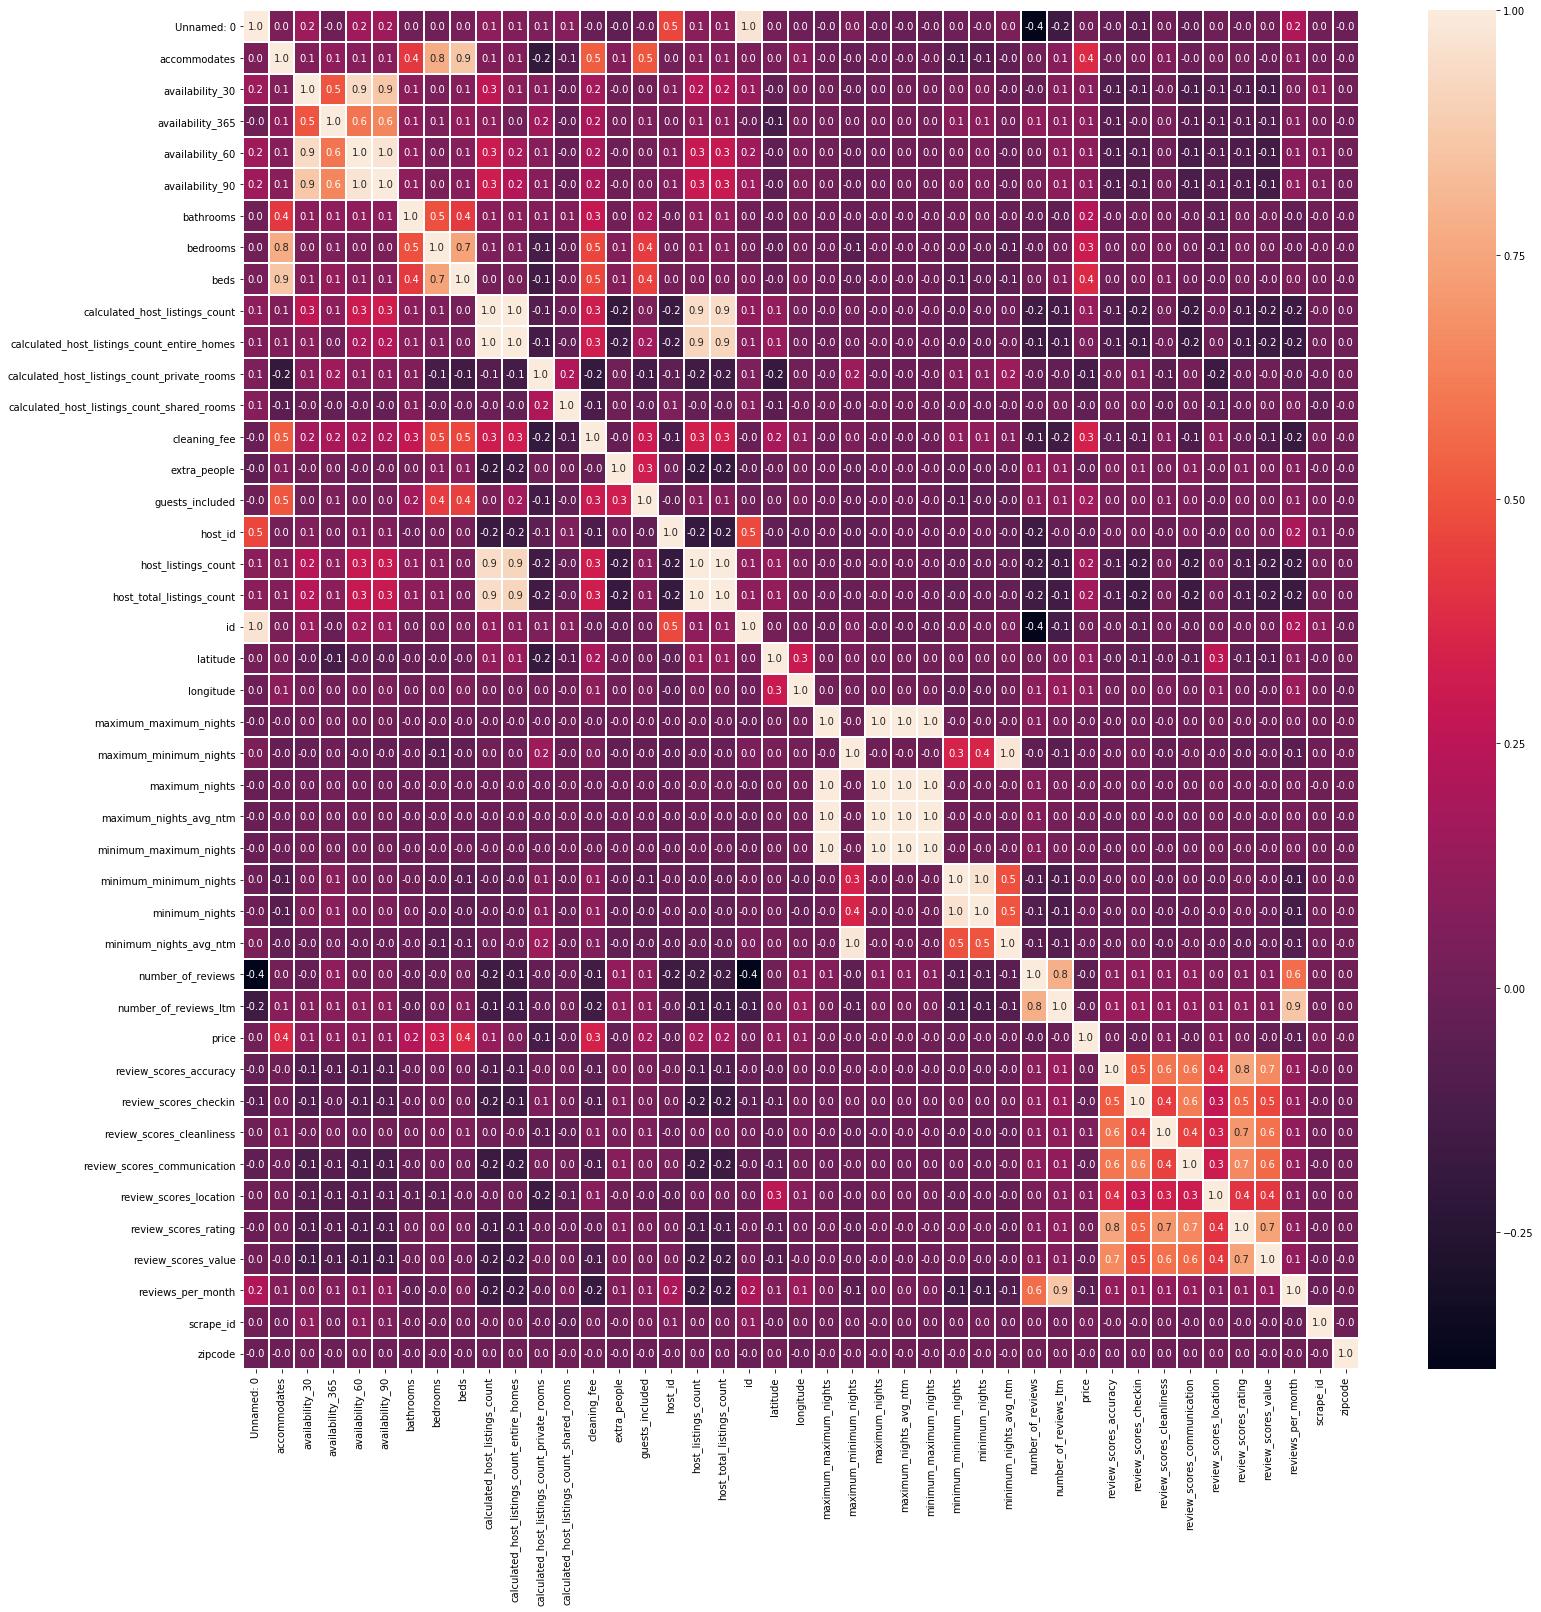

In [483]:
def heat_map(data):
    f, ax = plt.subplots(figsize=(25,25))
    sns.heatmap(data.corr(), annot = True, linewidths = 1, fmt = '.1f', ax=ax)
    plt.show()
    %matplotlib inline
heat_map(df)

## Dropping highly correlated and unnecessary columns:
#### Dropping features as they do not determine the price of the listing. Features such as host_id, host_has_profile_pic, access can be used after the host has posted the listing. These columns cannot be used to predict the price of the listing

In [484]:
def drop_again(data):
    data = data.drop(columns=['Unnamed: 0', 'access', 'availability_30', 'availability_365', 'availability_60', 
    'availability_90','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
    'calendar_last_scraped', 'calendar_updated', 'city','country', 'country_code',  'experiences_offered', 
    'first_review', 'has_availability', 'host_about', 'host_has_profile_pic', 'host_id',
    'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 
    'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 
    'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'house_rules', 'id', 
    'instant_bookable', 'interaction', 'is_location_exact', 'jurisdiction_names', 'last_review', 'last_scraped',
    'latitude', 'listing_url', 'longitude', 'market', 'maximum_maximum_nights', 'maximum_minimum_nights', 
    'maximum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights',
    'minimum_nights_avg_ntm', 'monthly_price', 'neighbourhood', 'notes', 'number_of_reviews',
    'number_of_reviews_ltm', 'picture_url', 'require_guest_phone_verification', 'extra_people','guests_included',
    'require_guest_profile_picture', 'requires_license', 'review_scores_accuracy', 'review_scores_checkin',
    'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location','review_scores_value',
    'reviews_per_month','scrape_id','smart_location', 'state', 'street','transit', 'weekly_price'])
    return data

df = drop_again(df)

In [485]:
def mean(data):
    mean_cleaning_fee = np.nanmean(data["cleaning_fee"])
    data["cleaning_fee"].fillna(value=mean_cleaning_fee, inplace=True)

    mean_review_scores_rating = np.nanmean(data["review_scores_rating"])
    data["review_scores_rating"].fillna(value=mean_review_scores_rating, inplace=True)
    return data
df = mean(df)

## Plotting the heat-map after dropping the irrelavant and correlated features

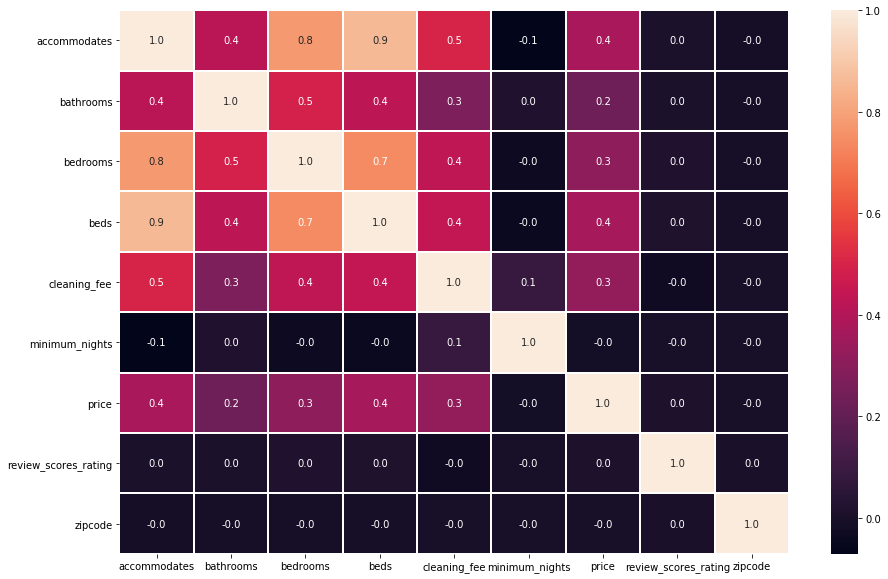

In [486]:
def heat_map1(data):
    f, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(data.corr(), annot = True, linewidths = 1, fmt = '.1f', ax=ax)
    plt.show()
    %matplotlib inline
    
heat_map1(df)

### Converting the amenities feature into a integer value by calculating the count of the amenities

In [487]:
def amenities(data):
    amen = data['amenities'].tolist()
    list = []
    ammenties_count = []
    for i in amen:
        list.append(i.split(','))
    for j in list:
        ammenties_count.append(len(j))
    data['ammenties_count'] = ammenties_count
    return data

df = amenities(df)

In [488]:
df.columns

Index(['accommodates', 'amenities', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'cleaning_fee', 'description',
       'is_business_travel_ready', 'minimum_nights', 'name',
       'neighborhood_overview', 'neighbourhood_cleansed', 'price',
       'property_type', 'review_scores_rating', 'room_type',
       'security_deposit', 'space', 'summary', 'zipcode', 'ammenties_count'],
      dtype='object')

In [489]:
df['bathrooms'].unique()

array([2. , 1. , 1.5, 2.5, 3.5, 3. , 4. , 0.5, 4.5, 0. , 5. , 6. ])

### Handling the categorical data by converting them into features using get_dummies function

In [490]:
def categorical(data):
    data = data.reset_index(drop=True)
    data = pd.get_dummies(data, columns =['bed_type','room_type','neighbourhood_cleansed',
                                          'property_type'], prefix = ['Bed','Room','Neighborhood',
                                                                      'Property'], drop_first = True)
    data.drop(columns=['amenities','description','name','neighborhood_overview','cancellation_policy',
                       'space','summary','security_deposit','is_business_travel_ready'], inplace=True)
    return data

df= categorical(df)

In [491]:
def price_limit(data):
    data = data[~(data[['price']] == 0).any(axis=1)]
    data = data[~(data['price'] > 500)]
    return data
df = price_limit(df)

In [506]:
data = df.copy()

## Splitting the data into test and train. 
#### Taking 20% of the data as test data and 80% as training data

In [507]:
y = data['price']
data.drop(columns=['price'], inplace=True)
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

## Creating a function where it accepts different Regression models to predict the price and return the MAPE values for train and test data 

In [494]:
def modelling(model, X_train, X_test, y_train, y_test):
    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test)
    model.fit(X_train, y_train)  
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    return [mape_train, mape_test,mae_train, mae_test, mse_test, rmse_test,y_pred_test]    

In [471]:
y_test.to_csv('../data/y_test_data.csv')
#X_test.to_csv('../data/X_testData.csv')

## Using Random Forest Regressor

In [498]:
model = RandomForestRegressor()
print(model)
metrices_list = modelling(model,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAPE for train is:  3.998563466938322 ,MAPE for test is:  8.41063968618403 ,MAE for train is:  5.926499472299692 ,MAE for test is:  11.730531090170308 ,MSE for test is:  938.9534147240307 ,RMSE for test is:  30.642346756148275


### Using k-fold validation with the best features

In [342]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
importances = model.feature_importances_
X_feat = data.values
Y_feat = y.values
print(kf) 

max_depth_list = [7,8,10,20,30,50,60]
for depth in max_depth_list:
    MAPE_TEST = []  
    MAPE_TRAIN =[]
    regressor = RandomForestRegressor(n_estimators='warn', max_depth= depth) 

    for i, j in kf.split(X_feat):
        X_train, X_test = X_feat[i], X_feat[j]
        y_train, y_test = Y_feat[i], Y_feat[j]
        result = modelling(regressor,X_train, X_test, y_train, y_test)
    MAPE_TEST.append(result[1])
    MAPE_TRAIN.append(result[0])
    print("depth = ",depth, MAPE_TEST)

KFold(n_splits=5, random_state=None, shuffle=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  7 [38.85587509435272]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  8 [38.20006543188057]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  10 [36.09127925872447]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  20 [35.893062018004365]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  30 [34.96016432649382]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  50 [35.33214335504373]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth =  60 [35.805695359896]


In [301]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf) 

n_estimator_list = [10,15,20,25,30,50,60]
for est in n_estimator_list:
    MAPE_TEST = []  
    MAPE_TRAIN =[]
    regressor = RandomForestRegressor(max_depth= 20,n_estimators = est) 

    for i, j in kf.split(X_feat):
        X_train, X_test = X_feat[i], X_feat[j]
        y_train, y_test = Y_feat[i], Y_feat[j]
        result = modelling(regressor,X_train, X_test, y_train, y_test)
    MAPE_TEST.append(result[1])
    MAPE_TRAIN.append(result[0])
    print("estimator = ",est, MAPE_TEST)

KFold(n_splits=5, random_state=None, shuffle=False)
estimator =  10 [35.667735730234895]
estimator =  15 [34.50469818420058]
estimator =  20 [35.4679778954081]
estimator =  25 [34.80529929335982]
estimator =  30 [35.316005185763764]
estimator =  50 [34.97602285977417]
estimator =  60 [34.95809098987604]


### Grid-search for Random Forest Regressor to find the best parameters

In [508]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf) 
regressor = RandomForestRegressor() 
param_grid = {"n_estimators": [20,25,30,40,200],
              "max_features": ['auto', 'sqrt', 'log2'],
             "max_depth": [10,15,20,30]}

grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

print(grid_search.score)

KFold(n_splits=5, random_state=None, shuffle=False)
<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 25, 30, 40, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>


In [510]:
grid_search.best_params_

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

### Using best parameters returned from the Grid Search to calculate the metrics of Random Forest Regressor

In [511]:
rgr = RandomForestRegressor(max_depth= 30,n_estimators = 200, max_features='sqrt' )
print(rgr)
metrices_list = modelling(rgr,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


MAPE for train is:  5.458842578087373 ,MAPE for test is:  9.385890962504781 ,MAE for train is:  7.300396737421629 ,MAE for test is:  12.463699339634214 ,MSE for test is:  818.9498733837917 ,RMSE for test is:  28.617300246246007


#### Using Random Forest model with the best parameters, that is, bootstrap=True, criterion='mse', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False

## Plotting the feature importance using the Random Forest Regressor

In [553]:
columns = ['accommodates','bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
                   'minimum_nights', 'review_scores_rating', 'zipcode','ammenties_count']
model.fit(X_train,y_train)
col =[]
imp=[]
for name, importance in zip(X_train[columns], model.feature_importances_):
    print(name, "has importance of =", importance)
    col.append(name)
    imp.append(importance)

accommodates has importance of = 0.04201882527350718
bathrooms has importance of = 0.09742423222218781
bedrooms has importance of = 0.029605749860932524
beds has importance of = 0.022507106083039193
cleaning_fee has importance of = 0.10010164571825172
minimum_nights has importance of = 0.045697433792544054
review_scores_rating has importance of = 0.04687077788593267
zipcode has importance of = 0.06101574638616465
ammenties_count has importance of = 0.08599672910054448


In [ ]:
feature_imp = pd.DataFrame()
feature_imp['column'] = col
feature_imp['imp'] = imp
feature_imp['column'] = feature_imp['column'].str.replace('accommodates','accom').replace('bathrooms','bath').replace('minimum_nights','min_night').replace('review_scores_rating','rate').replace('ammenties_count','ammenties').replace('cleaning_fee','CleanFee')

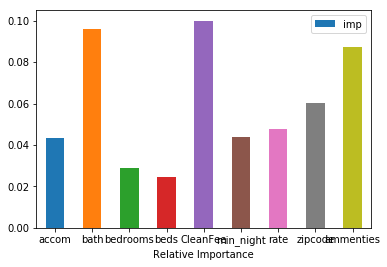

In [554]:
feature_imp.plot.bar(x='column', y='imp', rot=0)
plt.xlabel('Relative Importance')
plt.show()

## Using Decision Tree Regressor

In [501]:
model1 = tree.DecisionTreeRegressor()
print(model1)
metrices_list = modelling(model1,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


MAPE for train is:  1.679198740254469 ,MAPE for test is:  7.515810609685129 ,MAE for train is:  2.978320263960393 ,MAE for test is:  10.887561963137701 ,MSE for test is:  1265.6177508782146 ,RMSE for test is:  35.57552179347781


### Using grid-search to find the best parameters

In [276]:
def bestParameters():
        #regressor = tree.DecisionTreeRegressor() 

        # Set the parameters by cross-validation
        tuned_parameters = [{'max_features': ['sqrt', 'log2', None],
                             'max_depth': range(20,60,20),
                             }
                            ]


        reg = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=5)
        reg.fit(X_train, y_train)

        print ("Best parameters set found on development set:\n")
        print (reg.best_params_)

        
bestParameters()

Best parameters set found on development set:

{'max_depth': 40, 'max_features': 'sqrt'}


### Using best parameters to calculate the mape using Decision Tree Regressor

In [504]:
model2 = tree.DecisionTreeRegressor(max_features=None, max_depth = 40)
print(model2)
metrices_list = modelling(model2,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))

DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


MAPE for train is:  1.682999224208074 ,MAPE for test is:  7.490012697239937 ,MAE for train is:  2.9849879873829814 ,MAE for test is:  10.824572468375417 ,MSE for test is:  1222.0637952976292 ,RMSE for test is:  34.958029053389566


#### As we can see, the model works best with its default parameters. So, we are going to use Decision tree with its default paramenetr, that is, max_depth=None, max_features=None,random_state=None, splitter='best' 

## KNN Neighbors

In [505]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor() 
print(regressor)
metrices = modelling(regressor,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices[0]),',MAPE for test is: ', str(metrices[1]),
      ',MAE for train is: ', str(metrices[2]),',MAE for test is: ', str(metrices[3]), 
      ',MSE for test is: ', str(metrices[4]),',RMSE for test is: ',str(metrices[5]))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


MAPE for train is:  8.501841150105616 ,MAPE for test is:  12.19612160889695 ,MAE for train is:  11.856503926254694 ,MAE for test is:  16.600256060088764 ,MSE for test is:  1419.335694776374 ,RMSE for test is:  37.67407191658972


#### The MAPE of KNN model is comparatively higher than Decision Tree Regressor and Random Forest Regressor and so we are not performing grid-search on it. We are moving forward with Random Forest and Decision Tree Regressor to predict our prices.

## Pickling the final model

In [343]:
import pickle
ran_for = open('RandomForestModel.pkl', 'wb')
pickle.dump(model, ran_for)
print(ran_for)
ran_for.close()

decision_tree = open('DecisionTree.pkl', 'wb')
pickle.dump(model1, decision_tree)
print(decision_tree)
decision_tree.close()

<_io.BufferedWriter name='RandomForestModel.pkl'>
<_io.BufferedWriter name='DecisionTree.pkl'>


In [344]:
import pandas as pd
pickle_in = open('RandomForestModel.pkl', 'rb')
RFmodel = pickle.load(pickle_in)

pickle_decision_tree = open('DecisionTree.pkl', 'rb')
DTmodel = pickle.load(pickle_decision_tree)

pickle_in.close()
pickle_decision_tree.close()

## Creating function to predict the price from the pickled model

In [345]:
def predict_price_RF(df):
    return RFmodel.predict(df)

In [346]:
def predict_price_DT(df):
        return DTmodel.predict(df)

## Metrics Comparison table

<table class='table table-striped'> <thead> <tr> <th>Model</th> <th>MAPE train</th> <th>MAPE test</th><th>MAE(Mean Absolute Error) train</th> <th>MAE(Mean Absolute Error) test</th><th>RMSE test</th></tr> </thead> <tbody> 
        <tr> <th scope='row'>Random Forest Regressor</th> <td>4.02121067508137</td> <td>8.32511472354938</td> <td>5.97037630716774</td><td>11.673885095524515</td><td>30.683513100904698</td> </tr><tr> <th scope='row'>Decision Tree Regressor</th> <td>1.679198740254469</td> <td>7.380603823728396</td> <td>2.978320263960393</td> <td>10.692911586770014</td> <td>35.07912794557497</td> </tr> </tbody> </table>

## Comparing the models with respect to Interpretability and Reproducibility

#### Interpretability: Interpretability is the degree to which a human can understand the cause of a decision or the degree to which a human can consistently predict the model’s result
#### Reproducibility: It is the extent to which consistent results are obtained when an experiment is repeated.

<table class='table table-striped'> <thead> <tr> <th>Model</th> <th>Interpretable</th> <th>Reproducible</th></tr> </thead> 
<tbody><tr> <th scope='row'>Random Forest Regressor</th> <td>No</td> <td>Yes</td></tr>
<tr> <th scope='row'>Decision Tree Regressor</th> <td>Yes</td> <td>Yes</td></tr>
<tr> <th scope='row'>KNN Regressor</th> <td>No</td> <td>Yes</td></tr></tbody> </table>